# AIRBNB SEATTLE
This is an explanatory journey of the data provided by Airbnb seattle.

I've chose this dataset because I travel to Europe twice a year (I reside in Lebanon) and I believe that neighborhood is the most important factor then there are other issues like budget and how close is it to the metro station, then I start going through and reading the reviews because now I have handful of listings I can choose from. I wanted to validate if this applies to other travelers using the Seattle dataset.

# Questions I Believe worth Exploring

1. What are the most popular neighboorhoods in Seattle?
2. Within the neighborhood, do the highest rated listings price higher than others? in other words are ratings and prices correlated?
3. What is the most important variable affecting a listing rating and price?

In [1]:
# Import the needed libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
# Import the required dataset

seattle_cal = pd.read_csv('Data/AirBnB/seattle/calendar.csv')
seattle_list = pd.read_csv('Data/AirBnB/seattle/listings.csv')
seattle_rev = pd.read_csv('Data/AirBnB/seattle/reviews.csv')

In [206]:
# This function enables the me to see all the columns in the dataframe

def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [207]:
display_all(seattle_list.head())

,listing_id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern Hou

In [208]:
# There are 92 variables in the listing dataset with 3818 observations 
seattle_list.shape

(3818, 92)

In [209]:
seattle_list.columns

Index(['listing_id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type',

Looking at the listing file, we see 92 variables with 3,818 records

In [210]:
df = seattle_list.copy()

Rather than going through the explanatory journey, I will first clean the data and do some data engineering in one step

## Data Cleansing

### Drop variable that hold the same value in each and every observation

In [211]:
# This loop takes in all columns and returns true if the value of a column is the same all over the dataframe
empty_cols = []
for col in df.columns:
    if np.all(df.groupby(col).id.count() == 3818):
        empty_cols.append(col)

AttributeError: 'DataFrameGroupBy' object has no attribute 'id'

In [212]:
# These are the columns which are the same all over the records and add no value and has to be dropped
empty_cols

[]

In [213]:
# Drop these 11 columns from dataframe
df.drop(empty_cols, axis=1, inplace=True)

In [214]:
df.shape

(3818, 92)

### Drop variables with URL

It seems that every listing has its unique URL (totally expected) and can be dropped from the dataframe

In [12]:
col_url = df.columns[df.columns.str.contains('_url')]

In [13]:
col_url

Index(['listing_url', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url'],
      dtype='object')

In [14]:
df.drop(col_url, axis=1, inplace=True)

In [15]:
df.shape

(3818, 73)

### Drop the variable "Name"

I was thinking that the names shall be unique because no one wants to have his or her listing with the same of a competitor especially when they are in the same state and maybe city because a bad review or word of mouth can be harmful

> We hve 51 listings with the same name

In [16]:
# We have 51 listings with the same name
df.name.value_counts()[:25].sum()

51

> Is it an issue in the extration or do 2 different listing share the same name?

In [17]:
df.name.value_counts()[:25]

Capitol Hill Apartment                 3
Private bath walk UW U Village(202)    2
Privacy & gorgeous panoramic views!    2
Vintage Apt in Heart of CapitolHill    2
Luxury Apt/Downtown West Seattle       2
"THE 5-STAR HOUSE"                     2
Cozy studio in Capitol Hill!           2
Seattle Downtown Convention Center     2
Downtown Seattle Pike Place Market     2
Sans souci in Seattle                  2
Fabulous Seattle Modern                2
comfy room&convenient location（中英）     2
Capitol Hill Master Bedroom            2
Secluded Setting in North Seattle      2
A Quiet Room in a House by the Lake    2
Center UW Blast Internet New #102      2
Downtown studio close to everything    2
Private room in West Seattle           2
Cozy Ballard Apartment                 2
2 Baths W/D,View walk UW (302)         2
Ravenna Retreat                        2
Charming Craftsman in Ballard          2
In-City Suite Retreat                  2
Capitol Hill Studio Apartment          2
Bedroom in artis

In [18]:
df.groupby(['name', 'id']).id.count().sort_values(ascending=False).head()

name                             id     
• West Seattle Crash Pad •       8102349    1
Cozy Room West Seattle           6888107    1
Cozy Seattle Bungalow            6729818    1
Cozy Seattle Bedroom             9823290    1
Cozy Seattle Apartment Near UW   202260     1
Name: id, dtype: int64

In [19]:
display_all(df[df.name == 'comfy room&convenient location（中英）'])

,id,name,summary,space,description,neighborhood_overview,notes,transit,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,smart_location,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
1958,9814376,comfy room&convenient location（中英）,"clean and comfy bedroom&bathroom,located in to...","Big,quiet and clean room in lovely townhouse,r...","clean and comfy bedroom&bathroom,located in to...",Located in townhouse and features a wide array...,"For some reasons,the owner is not sleep in the...","clean and comfy bedroom&bathroom,located in to...",50557855,Hua,2015-12-05,US,NaN,within a day,100%,NaN,f,Holly Park,2.0,2.0,"['email', 'phone', 'google', 'jumio']",t,t,"South Holly Park Drive, Seattle, WA 98118, Uni...",Holly Park,South Beacon Hill,Beacon Hill,Seattle,WA,98118,"Seattle, WA",47.535245,-122.284865,t,Townhouse,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Free Parking on Premises...",NaN,$60.00,NaN,NaN,$100.00,$15.00,1,$0.00,1,1125,a week ago,30,60,90,365,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,moderate,f,f,2,NaN
2052,9863457,comfy room&convenient location（中英）,"clean and comfy bedroom&bathroom,located in to...","Big,quiet and clean room in lovely townhouse,r...","clean and comfy bedroom&bathroom,located in to...",Located in townhouse and features a wide array...,"The guest can use the whole building,including...","clean and comfy bedroom&bathroom,located in to...",50557855,Hua,2015-12-05,US,NaN,within a day,100%,NaN,f,Holly Park,2.0,2.0,"['email', 'phone', 'google', 'jumio']",t,t,"South Holly Park Drive, Seattle, WA 98118, Uni...",Holly Park,Holly Park,Beacon Hill,Seattle,WA,98118,"Seattle, WA",47.536681,-122.286116,t,Townhouse,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Free Parking on Premises...",NaN,$50.00,NaN,NaN,$100.00,$15.00,1,$0.00,1,1125,a week ago,30,60,90,365,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,f,f,2,NaN


Although after manual inspection of these properties, it seems that these listings are not duplicates due to an error in data extarction but it is clear that although they are very similar, these are 2 distinct listings and can't be dropped, but for analysis purposes I believe the name holds little value and can be dropped especially that it is mostly a combination of the apartment or room location and some features 

In [20]:
df.drop('name', axis=1, inplace=True)

### Drop variable with high Null values

In [21]:
df.columns[df.isnull().sum()/len(df) > .75]

Index(['square_feet'], dtype='object')

In [22]:
df.drop(['square_feet'], axis=1,inplace=True)

In [23]:
df.shape

(3818, 71)

### Drop redundant variables

For a proper analysis, I need to make sure that there are no redundant variables 

Since some variables will look different but essentially they are the same but abbreviated, I will factorize all the variables

In [24]:
factor_df =  pd.DataFrame()

for col in df.columns:
    factor_df[col] = df[col].factorize()[0]

In [25]:
# loop over the encoded dataframe against itself to see if there are any columns with similar values
dupl_dict = {}
for index, col_1 in enumerate(factor_df.columns):
    for col_2 in factor_df.columns[index + 1:]:
        if np.all(factor_df[col_1] == factor_df[col_2]):
            dupl_dict[col_1] = col_2

In [26]:
dupl_dict

{'id': 'longitude',
 'host_listings_count': 'host_total_listings_count',
 'city': 'smart_location',
 'latitude': 'longitude'}

We have some duplicates, some are expected since when encoding, every number is given a code and columns like latitude, longitude and id will seem similar because they have totally distinct values and when enoded will look the same, but the value of this exercise is visible in the below variables

In [27]:
df.host_listings_count.value_counts().head(3)

1.0    2179
2.0     620
3.0     261
Name: host_listings_count, dtype: int64

In [28]:
df.host_total_listings_count.value_counts().head(3)

1.0    2179
2.0     620
3.0     261
Name: host_total_listings_count, dtype: int64

In [29]:
df.city.value_counts()

Seattle                  3810
Seattle                     2
West Seattle                2
seattle                     1
Phinney Ridge Seattle       1
Ballard, Seattle            1
西雅图                         1
Name: city, dtype: int64

In [30]:
df.smart_location.value_counts()

Seattle, WA                  3810
West Seattle, WA                2
Seattle , WA                    2
西雅图, WA                         1
Phinney Ridge Seattle, WA       1
seattle, wa                     1
Ballard, Seattle, WA            1
Name: smart_location, dtype: int64

I will drop one of these pair of duplicate variables

In [31]:
df.drop(['smart_location', 'host_total_listings_count'], axis=1, inplace=True)

In [32]:
df.shape

(3818, 69)

### Drop some variables that upon eyeballing looks useless

Still looking at city it hold no value as it is all data from Seattle, same for state

In [33]:
df.state.value_counts()

WA    3817
wa       1
Name: state, dtype: int64

In [34]:
df.city.value_counts()

Seattle                  3810
Seattle                     2
West Seattle                2
seattle                     1
Phinney Ridge Seattle       1
Ballard, Seattle            1
西雅图                         1
Name: city, dtype: int64

In [35]:
# Drop city and state as we are only looking into Seattle
df.drop(['state', 'city'], axis=1, inplace=True)

Drop neighbourhood as it is the same as neighbourhood_cleansed with missing values

In [36]:
df.drop('neighbourhood', axis=1, inplace=True)

In [37]:
df.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [38]:
df.shape

(3818, 64)

Dropping latitide and longitute as they serve little value to answer the questions

### Fix the one strange ZIPCODE

In [39]:
# Fix the error in this specific ZipCode manually
df.loc[df.zipcode == '99\n98122', 'zipcode'] = '98122'

### Strip the street variable

In [40]:
df.street.value_counts().head()

1st Avenue, Seattle, WA 98101, United States          30
Hubbell Place, Seattle, WA 98101, United States       29
12th Avenue East, Seattle, WA 98102, United States    29
East Denny Way, Seattle, WA 98122, United States      28
10th Avenue East, Seattle, WA 98102, United States    28
Name: street, dtype: int64

In [41]:
# Drop all the rest from street as they are visible in other variables like ZipCode
df.street = df.street.str.split(',', expand=True)[0].copy()

In [42]:
df.street.value_counts().head()

1st Avenue          55
2nd Avenue          35
Western Avenue      33
10th Avenue East    29
12th Avenue East    29
Name: street, dtype: int64

#### Going from 92 to 64 variables was quite simple because we simply dropped all redundant, empty and useless variables and here is the dataframe in its current form

Now it gets tricky because we have free text variables like summary and space which looks useless but indeed very useful, and we have some variables like zipcode and host_verifications looks empty but can be useful upon slicing

# Feature Engineering

### Treating Host Name

In [43]:
df.host_name[5:8]

5           Andrew
6    Gary And Beth
7        Jean-Marc
Name: host_name, dtype: object

The host name doesnt look a lot but upon checking them I noticed that there are singles and couples hosts which makes it interesting to see if such a variable affects a person decisions

In [44]:
pattern = '&|And '
conditions = [(df.host_name.str.contains(pattern) == True), (df.host_name.str.contains(pattern) == False)]
choices = ['Couple', 'Singles']

In [45]:
df['host_type'] = np.select(conditions, choices)

In [46]:
df.host_type.value_counts()

Singles    3485
Couple      331
0             2
Name: host_type, dtype: int64

In [47]:
df[df.host_type == '0'].host_name

1297    NaN
1419    NaN
Name: host_name, dtype: object

In [48]:
df.drop(['host_name'], axis=1, inplace=True)

### The Amazing Text Variables

The below are a bit challenging because they are free text but definitly we can extract some useful keywords

In [49]:
text_var = list(df[['summary', 'space', 'description', \
               'neighborhood_overview', 'notes', 'transit', 'host_location', 'host_about']].columns)

In [50]:
# Before any treatment, I'll impute the missing variables in each record
# I will impute with 'No Info' because this will help me track the value of these texts if useful

df[text_var] = df[text_var].fillna('no info')

1. Create a variable with the number of characters
2. Create size of distinct words
3. Add frequency of top 25 words

In [51]:
# 1. Create a variable with the number of characters
for col in text_var:
    df[col+'_size'] = df[col].str.len()

In [52]:
# 2. Create size of distinct words
for col in text_var:
    df[col+'_count'] = df[col].str.lower().str.split().str.len()

In [53]:
# 3. Add frequency of top 25 words after dropping all the stopwords
txt_vect = feature_extraction.text.TfidfVectorizer(max_features=25, stop_words='english')

for col in text_var:
    matrix = txt_vect.fit_transform(df[col])
    matrix_df = pd.DataFrame(matrix.toarray(), columns=txt_vect.get_feature_names())
    
    for i in matrix_df:
        df[col+'_tf_'+str(i)] = matrix_df[i]

In [54]:
# Drop all these text variables
df.drop(text_var, axis=1, inplace=True)

In [55]:
len(df.columns)

272

### Extracting variables from Host Verfication

I decided to create dummy variables from host verifications because keeping them in lists will dillute the value of each communiction channel

In [56]:
# Get list of ways to contact each of the 
vectorizer = CountVectorizer()
tk_count = vectorizer.fit_transform(df['host_verifications'])
contact_list = vectorizer.get_feature_names()
contact_list

['amex',
 'email',
 'facebook',
 'google',
 'jumio',
 'kba',
 'linkedin',
 'manual_offline',
 'manual_online',
 'none',
 'phone',
 'photographer',
 'reviews',
 'sent_id',
 'weibo']

In [57]:
# Here I will break down the communication channels into new columns
contact_df = pd.DataFrame(tk_count.toarray(), columns=vectorizer.get_feature_names())
    
for i in contact_df:
    df[col+'_WC_'+ str(i)] = contact_df[i]

In [58]:
df.drop('host_verifications', axis=1, inplace=True)

In [59]:
df.shape

(3818, 286)

In [60]:
vectorizer = CountVectorizer(stop_words='english') 
amenities_features = vectorizer.fit_transform(df.amenities)
amenities_df = pd.DataFrame(amenities_features.toarray(), columns=vectorizer.get_feature_names())

amenities_df.rename(index=str,columns={'24':'24hrs'}, inplace=True)

In [61]:
df = pd.concat([df.reset_index(), amenities_df.reset_index()], axis=1)

In [62]:
df.drop(['index', 'amenities'], axis=1, inplace=True)

In [63]:
display_all(df.head())

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_type,summary_size,space_size,description_size,neighborhood_overview_size,notes_size,transit_size,host_location_size,host_about_size,summary_count,space_count,description_count,neighborhood_overview_count,notes_count,transit_count,host_location_count,host_about_count,summary_tf_apartment,summary_tf_bathroom,summary_tf_bed,summary_tf_bedroom,summary_tf_blocks,summary_tf_bus,summary_tf_capitol,summary_tf_close,summary_tf_downtown,summary_tf_great,summary_tf_hill,summary_tf_home,summary_tf_just,summary_tf_kitchen,summary_tf_lake,summary_tf_located,summary_tf_neighborhood,summary_tf_private,summary_tf_queen,summary_tf_quiet,summary_tf_restaurants,summary_tf_room,summary_tf_seattle,summary_tf_space,summary_tf_walk,space_tf_apartment,space_tf_area,space_tf_bathroom,space_tf_bed,space_tf_bedroom,space_tf_downtown,space_tf_floor,space_tf_great,space_tf_home,space_tf_house,space_tf_just,space_tf_kitchen,space_tf_large,space_tf_living,space_tf_located,space_tf_neighborhood,space_tf_new,space_tf_place,space_tf_private,space_tf_queen,space_tf_room,space_tf_seattle,space_tf_size,space_tf_space,space_tf_walk,description_tf_access,description_tf_apartment,description_tf_away,description_tf_bathroom,description_tf_bed,description_tf_bedroom,description_tf_bus,description_tf_downtown,description_tf_floor,description_tf_great,description_tf_hill,description_tf_home,description_tf_house,description_tf_just,description_tf_kitchen,description_tf_living,description_tf_located,description_tf_neighborhood,description_tf_private,description_tf_queen,description_tf_restaurants,description_tf_room,description_tf_seattle,description_tf_space,description_tf_walk,neighborhood_overview_tf_away,neighborhood_overview_tf_bars,neighborhood_overview_tf_blocks,neighborhood_overview_tf_center,neighborhood_overview_tf_city,neighborhood_overview_tf_close,neighborhood_overview_tf_coffee,neighborhood_overview_tf_downtown,neighborhood_overview_tf_great,neighborhood_overview_tf_hill,neighborhood_overview_tf_info,neighborhood_overview_tf_just,neighborhood_overview_tf_lake,neighborhood_overview_tf_located,neighborhood_overview_tf_market,neighborhood_overview_tf_minute,neighborhood_overview_tf_minutes,neighborhood_overview_tf_neighborhood,neighborhood_overview_tf_park,neighborhood_overview_tf_place,neighborhood_overview_tf_restaurants,neighborhood_overview_tf_seattle,neighborhood_overview_tf_shops,neighborhood_overview_tf_walk,neighborhood_overview_tf_walking,notes_tf_apartment,notes_tf_available,notes_tf_bedroom,notes_tf_building,notes_tf_check,notes_tf_cleaning,notes_tf_free,notes_tf_guest,notes_tf_guests,notes_tf_home,notes_tf_house,notes_tf_info,notes_tf_just,notes_tf_know,notes_tf_need,notes_tf_night,notes_tf_note,notes_tf_parking,notes_tf_room,notes_tf_seattle,notes_tf_space,notes_tf_stay,notes_tf_street,notes_tf_time,notes_tf_use,transit_tf_10,transit_tf_airport,transit_tf_away,transit_tf_block,transit_tf_blocks,transit_tf_bus,transit_tf_car,transit_tf_downtown,transit_tf_easy,transit_tf_house,transit_tf_info,transit_tf_just,transit_tf_light,transit_tf_lines,transit_tf_minute,transi

### Number of listings by host

Here we will add the number of listing by each host, the goal is to know whether if it is a side business or a focused business helps ingetting more bookings

In [64]:
# hostid_df = 
hostid_df = df.host_id.value_counts().to_frame().reset_index()
hostid_df.rename(columns={'index':'host_id', 'host_id':'host_listings'}, inplace=True)

In [65]:
df = df.merge(hostid_df, on='host_id')

In [66]:
df.host_listings.value_counts()/len(df)*100

1     59.848088
2     15.557884
3      6.678889
4      3.981142
5      2.357255
46     1.204819
39     1.021477
37     0.969094
36     0.942902
34     0.890519
33     0.864327
10     0.785752
6      0.785752
9      0.707177
12     0.628601
11     0.576218
7      0.550026
21     0.550026
18     0.471451
16     0.419068
8      0.209534
Name: host_listings, dtype: float64

In [67]:
display_all(df.head())

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_type,summary_size,space_size,description_size,neighborhood_overview_size,notes_size,transit_size,host_location_size,host_about_size,summary_count,space_count,description_count,neighborhood_overview_count,notes_count,transit_count,host_location_count,host_about_count,summary_tf_apartment,summary_tf_bathroom,summary_tf_bed,summary_tf_bedroom,summary_tf_blocks,summary_tf_bus,summary_tf_capitol,summary_tf_close,summary_tf_downtown,summary_tf_great,summary_tf_hill,summary_tf_home,summary_tf_just,summary_tf_kitchen,summary_tf_lake,summary_tf_located,summary_tf_neighborhood,summary_tf_private,summary_tf_queen,summary_tf_quiet,summary_tf_restaurants,summary_tf_room,summary_tf_seattle,summary_tf_space,summary_tf_walk,space_tf_apartment,space_tf_area,space_tf_bathroom,space_tf_bed,space_tf_bedroom,space_tf_downtown,space_tf_floor,space_tf_great,space_tf_home,space_tf_house,space_tf_just,space_tf_kitchen,space_tf_large,space_tf_living,space_tf_located,space_tf_neighborhood,space_tf_new,space_tf_place,space_tf_private,space_tf_queen,space_tf_room,space_tf_seattle,space_tf_size,space_tf_space,space_tf_walk,description_tf_access,description_tf_apartment,description_tf_away,description_tf_bathroom,description_tf_bed,description_tf_bedroom,description_tf_bus,description_tf_downtown,description_tf_floor,description_tf_great,description_tf_hill,description_tf_home,description_tf_house,description_tf_just,description_tf_kitchen,description_tf_living,description_tf_located,description_tf_neighborhood,description_tf_private,description_tf_queen,description_tf_restaurants,description_tf_room,description_tf_seattle,description_tf_space,description_tf_walk,neighborhood_overview_tf_away,neighborhood_overview_tf_bars,neighborhood_overview_tf_blocks,neighborhood_overview_tf_center,neighborhood_overview_tf_city,neighborhood_overview_tf_close,neighborhood_overview_tf_coffee,neighborhood_overview_tf_downtown,neighborhood_overview_tf_great,neighborhood_overview_tf_hill,neighborhood_overview_tf_info,neighborhood_overview_tf_just,neighborhood_overview_tf_lake,neighborhood_overview_tf_located,neighborhood_overview_tf_market,neighborhood_overview_tf_minute,neighborhood_overview_tf_minutes,neighborhood_overview_tf_neighborhood,neighborhood_overview_tf_park,neighborhood_overview_tf_place,neighborhood_overview_tf_restaurants,neighborhood_overview_tf_seattle,neighborhood_overview_tf_shops,neighborhood_overview_tf_walk,neighborhood_overview_tf_walking,notes_tf_apartment,notes_tf_available,notes_tf_bedroom,notes_tf_building,notes_tf_check,notes_tf_cleaning,notes_tf_free,notes_tf_guest,notes_tf_guests,notes_tf_home,notes_tf_house,notes_tf_info,notes_tf_just,notes_tf_know,notes_tf_need,notes_tf_night,notes_tf_note,notes_tf_parking,notes_tf_room,notes_tf_seattle,notes_tf_space,notes_tf_stay,notes_tf_street,notes_tf_time,notes_tf_use,transit_tf_10,transit_tf_airport,transit_tf_away,transit_tf_block,transit_tf_blocks,transit_tf_bus,transit_tf_car,transit_tf_downtown,transit_tf_easy,transit_tf_house,transit_tf_info,transit_tf_just,transit_tf_light,transit_tf_lines,transit_tf_minute,transi

# Treating Null Values

In [68]:
df.isnull().sum().sort_values(ascending = False)/len(df)*100

monthly_price                     60.267156
security_deposit                  51.126244
weekly_price                      47.380828
cleaning_fee                      26.977475
host_acceptance_rate              20.246202
review_scores_accuracy            17.234154
review_scores_checkin             17.234154
review_scores_value               17.181771
review_scores_location            17.155579
review_scores_cleanliness         17.103195
review_scores_communication       17.050812
review_scores_rating              16.946045
first_review                      16.422211
reviews_per_month                 16.422211
last_review                       16.422211
host_response_rate                13.698271
host_response_time                13.698271
host_neighbourhood                 7.857517
bathrooms                          0.419068
zipcode                            0.183342
bedrooms                           0.157150
host_since                         0.052383
host_is_superhost               

### Security deposit

I will impute the security deposit with zero since if it is not available, then the host is not requesting a deposit and thus it is free

In [69]:
df.security_deposit.fillna(0, inplace=True)

### Weekly_Price , Monthly_Price, Cleaning_fee

Since I will be using price as a target variable, I will convert weekly and monthly to categorical variables, since if it is null, then the host does not engage in long term commitments

In [70]:
df.weekly_price.head()

0          NaN
1          NaN
2          NaN
3    $1,000.00
4    $1,000.00
Name: weekly_price, dtype: object

In [71]:
# This function converts continous variables to categotical with levels yes for not null and no for null
def cont_to_cat(df, col):
    condition = [df[col].notnull(), df[col].isnull()]
    choice = ['yes', 'no']
    df[col+'_cat'] = np.select(condition, choice)
    df.drop([col], axis=1, inplace=True)

In [72]:
# Convert these variable to categorical with values yes for if not null and no if null
cont_to_cat(df, 'monthly_price')
cont_to_cat(df, 'weekly_price')
cont_to_cat(df, 'cleaning_fee')

### host_acceptance_rate

This has 26% null values but upon looking at the rest it is all 100% which doesn't make sence as and will drop it

In [73]:
df.host_acceptance_rate.value_counts()

100%    3044
0%         1
Name: host_acceptance_rate, dtype: int64

In [74]:
df.drop('host_acceptance_rate',axis=1, inplace=True)

### Nulls in review variables

In [75]:
df.review_scores_accuracy.fillna(0, inplace=True)
df.review_scores_checkin.fillna(0, inplace=True)
df.review_scores_value.fillna(0, inplace=True)
df.review_scores_location.fillna(0, inplace=True)
df.review_scores_cleanliness.fillna(0, inplace=True)
df.review_scores_communication.fillna(0, inplace=True)
df.review_scores_rating.fillna(0, inplace=True)
df.reviews_per_month.fillna(0, inplace=True)
df.host_response_time.fillna(0, inplace=True)
df.host_response_rate.fillna(0, inplace=True)
df.first_review.fillna(0, inplace=True)
df.last_review.fillna(0, inplace=True)

### Variable host_neighbourhood

I will drop this variable because its content and that of the neighbourhood_cleansed is the same with less details

In [76]:
df.drop('host_neighbourhood', axis=1, inplace=True)

In [77]:
display_all(df.head(2))

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_type,summary_size,space_size,description_size,neighborhood_overview_size,notes_size,transit_size,host_location_size,host_about_size,summary_count,space_count,description_count,neighborhood_overview_count,notes_count,transit_count,host_location_count,host_about_count,summary_tf_apartment,summary_tf_bathroom,summary_tf_bed,summary_tf_bedroom,summary_tf_blocks,summary_tf_bus,summary_tf_capitol,summary_tf_close,summary_tf_downtown,summary_tf_great,summary_tf_hill,summary_tf_home,summary_tf_just,summary_tf_kitchen,summary_tf_lake,summary_tf_located,summary_tf_neighborhood,summary_tf_private,summary_tf_queen,summary_tf_quiet,summary_tf_restaurants,summary_tf_room,summary_tf_seattle,summary_tf_space,summary_tf_walk,space_tf_apartment,space_tf_area,space_tf_bathroom,space_tf_bed,space_tf_bedroom,space_tf_downtown,space_tf_floor,space_tf_great,space_tf_home,space_tf_house,space_tf_just,space_tf_kitchen,space_tf_large,space_tf_living,space_tf_located,space_tf_neighborhood,space_tf_new,space_tf_place,space_tf_private,space_tf_queen,space_tf_room,space_tf_seattle,space_tf_size,space_tf_space,space_tf_walk,description_tf_access,description_tf_apartment,description_tf_away,description_tf_bathroom,description_tf_bed,description_tf_bedroom,description_tf_bus,description_tf_downtown,description_tf_floor,description_tf_great,description_tf_hill,description_tf_home,description_tf_house,description_tf_just,description_tf_kitchen,description_tf_living,description_tf_located,description_tf_neighborhood,description_tf_private,description_tf_queen,description_tf_restaurants,description_tf_room,description_tf_seattle,description_tf_space,description_tf_walk,neighborhood_overview_tf_away,neighborhood_overview_tf_bars,neighborhood_overview_tf_blocks,neighborhood_overview_tf_center,neighborhood_overview_tf_city,neighborhood_overview_tf_close,neighborhood_overview_tf_coffee,neighborhood_overview_tf_downtown,neighborhood_overview_tf_great,neighborhood_overview_tf_hill,neighborhood_overview_tf_info,neighborhood_overview_tf_just,neighborhood_overview_tf_lake,neighborhood_overview_tf_located,neighborhood_overview_tf_market,neighborhood_overview_tf_minute,neighborhood_overview_tf_minutes,neighborhood_overview_tf_neighborhood,neighborhood_overview_tf_park,neighborhood_overview_tf_place,neighborhood_overview_tf_restaurants,neighborhood_overview_tf_seattle,neighborhood_overview_tf_shops,neighborhood_overview_tf_walk,neighborhood_overview_tf_walking,notes_tf_apartment,notes_tf_available,notes_tf_bedroom,notes_tf_building,notes_tf_check,notes_tf_cleaning,notes_tf_free,notes_tf_guest,notes_tf_guests,notes_tf_home,notes_tf_house,notes_tf_info,notes_tf_just,notes_tf_know,notes_tf_need,notes_tf_night,notes_tf_note,notes_tf_parking,notes_tf_room,notes_tf_seattle,notes_tf_space,notes_tf_stay,notes_tf_street,notes_tf_time,notes_tf_use,transit_tf_10,transit_tf_airport,transit_tf_away,transit_tf_block,transit_tf_blocks,transit_tf_bus,transit_tf_car,transit_tf_downtown,transit_tf_easy,transit_tf_house,transit_tf_info,transit_tf_just,transit_tf_light,transit_tf_lines,transit_tf_minute,transit_tf_minutes,transit_tf_parking,transit_tf_public,transit_tf_rail,transit_tf_rid

### Missing data in Categorical Variables

Below are set of categorical which wil be filled with the most occuring level 

In [78]:
df.isnull().sum().sort_values(ascending = False)/len(df)*100

bathrooms                         0.419068
zipcode                           0.183342
bedrooms                          0.157150
host_is_superhost                 0.052383
host_has_profile_pic              0.052383
host_listings_count               0.052383
host_identity_verified            0.052383
host_since                        0.052383
beds                              0.026192
property_type                     0.026192
description_tf_access             0.000000
space_tf_walk                     0.000000
description_tf_apartment          0.000000
description_tf_away               0.000000
description_tf_bathroom           0.000000
space_tf_space                    0.000000
description_tf_bed                0.000000
description_tf_bedroom            0.000000
cleaning_fee_cat                  0.000000
description_tf_bus                0.000000
description_tf_downtown           0.000000
space_tf_seattle                  0.000000
description_tf_floor              0.000000
description

In [79]:
df.bathrooms.fillna(0, inplace=True)

In [80]:
df.zipcode.fillna('98122', inplace=True)

In [81]:
df.bedrooms.fillna(0, inplace=True)

In [82]:
df.host_since.fillna('2013-08-30', inplace=True)

In [83]:
df.host_is_superhost.fillna('f', inplace=True)

In [84]:
df.host_has_profile_pic.fillna('t', inplace=True)

In [85]:
df.host_identity_verified.fillna('t', inplace=True)

In [86]:
df.beds.fillna('1', inplace=True)

In [87]:
df.property_type.fillna('House', inplace=True)

In [88]:
# I will drop host listing count as it has nulls and I already created a similar variable usign current data
df.drop('host_listings_count', axis=1, inplace=True)

## Treating datetime data

We have 3 datetime variables that are of type object and needs to be transfered to date and the to discrete variables

host_since, first_review, last_review

In [89]:
# This function converts datetime variables to new discrete variables and drops existing
def date_to_num(df, col):
    for i in ['day', 'month', 'year']:
        df[col] = pd.to_datetime(df[col])
        df[col+'_'+i] = getattr(df[col].dt, i.lower())
#         df = df.drop(col, axis=1, inplace=True)
        

In [90]:
date_to_num(df, 'host_since')
date_to_num(df, 'first_review')
date_to_num(df, 'last_review')

In [91]:
df.drop(['host_since', 'first_review', 'last_review'], axis=1, inplace=True)

## Convert the values with "$" to numeric

In [121]:
# These are object or string when they need to be numerical
df.price.dtypes, df.extra_people.dtypes

(dtype('O'), dtype('O'))

In [129]:
df.price = df.price.str.replace('$', '')
df.extra_people = df.extra_people.str.replace('$', '')

In [138]:
df.price = df.price.str.replace(',', '')
df.extra_people = df.extra_people.str.replace(',', '')

In [140]:
# Convert to numeric
df.price = df.price.astype(float)
df.extra_people = df.extra_people.astype(float)

In [141]:
df.price.dtypes, df.extra_people.dtypes

(dtype('float64'), dtype('float64'))

In [184]:
df.shape

(3818, 351)

There are 351 variables and really by looking at them and even exploring them in an EDA style is not and option. I will look into a machine learning approach to choose top variables but it is not clear what the target variable shall be because we dont have number of booking or revenue by listing

## Looking for a Target Variable

The closest is price, but it can't be a clear target variables because the listings we are comapring here are not the same especially in number of people it can accommodate at once

In [186]:
df.room_type.value_counts()

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

In [187]:
df.groupby('room_type').price.mean()

room_type
Entire home/apt    155.843369
Private room        75.044828
Shared room         47.547009
Name: price, dtype: float64

As visible, average price varies a lot between the different types of listings

In [190]:
# df.columns

In [191]:
seattle_rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


I will assume that every review is a booking and it makes sense to include the minimum number of nights per review and multiply them by the price per note

In [199]:
df['rev'] = df.price * df.minimum_nights * df.number_of_reviews

In [201]:
df['rev']

0       17595.0
1          50.0
2        3910.0
3       12900.0
4        9600.0
5       13300.0
6        3600.0
7       15000.0
8        4250.0
9       78000.0
10      14400.0
11          0.0
12      17100.0
13       6600.0
14       2040.0
15      13920.0
16      20760.0
17       7200.0
18      19620.0
19      22920.0
20       2756.0
21       2160.0
22      51585.0
23       2376.0
24       9555.0
25        990.0
26      24894.0
27        327.0
28       5544.0
29       8910.0
         ...   
3788      120.0
3789    37375.0
3790    13680.0
3791        0.0
3792    12177.0
3793     3960.0
3794      800.0
3795     1610.0
3796    26250.0
3797     1870.0
3798        0.0
3799    17004.0
3800     4494.0
3801     4000.0
3802    39610.0
3803      210.0
3804      650.0
3805        0.0
3806    12096.0
3807        0.0
3808     3000.0
3809     2000.0
3810      763.0
3811     4800.0
3812     1540.0
3813      130.0
3814      316.0
3815        0.0
3816        0.0
3817        0.0
Name: rev, Length: 3818,

# Question 1: What are the most popular neighboorhoods in Seattle?

In [157]:
top_neighbour = df.neighbourhood_cleansed.value_counts()[:10]
top_neighbour

Broadway                     397
Belltown                     234
Wallingford                  167
Fremont                      158
Minor                        135
University District          122
Stevens                      119
First Hill                   108
Central Business District    103
Lower Queen Anne              94
Name: neighbourhood_cleansed, dtype: int64

In [160]:
top_10_hoods = list(top_neighbour.to_frame().index)

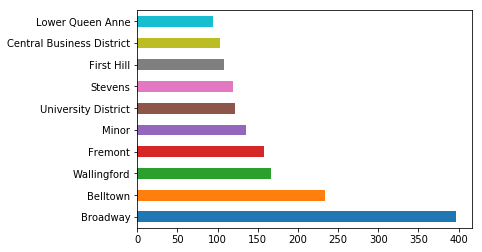

In [110]:
top_neighbour.plot('barh')
plt.show()

Although we don't have the number of booking per listing but for the fact that Broadway has almost double the number of lsiting in comparison to the next neighborhood in list means that this is a popular destination in Seattle

Lets check some attributed of this neighborhood that might be interesting

In [144]:
df[df.neighbourhood_cleansed == 'Broadway'].price.describe()

count    397.000000
mean     123.889169
std       77.628634
min       25.000000
25%       79.000000
50%      100.000000
75%      150.000000
max      673.000000
Name: price, dtype: float64

In [ ]:
top_10_hoods

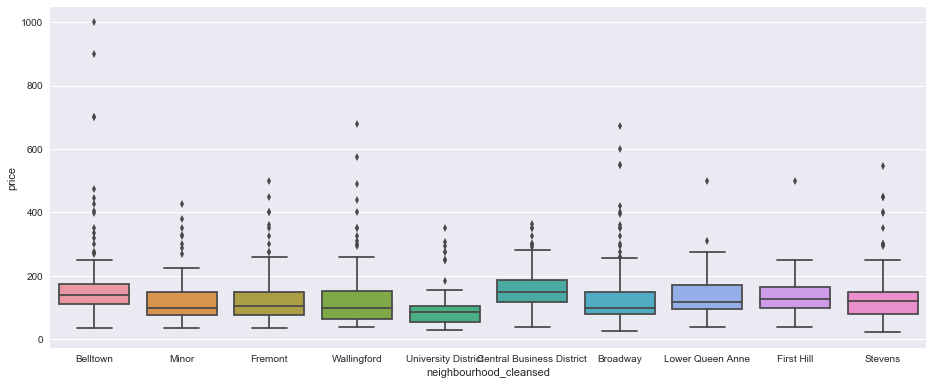

In [172]:
sns.set(rc={'figure.figsize':(15.7,6.27)})
sns.boxplot(x='neighbourhood_cleansed', y='price', data=df[df.neighbourhood_cleansed.isin(top_10_hoods)])
plt.show()